In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers
import random

In [ ]:
# Colab Drive Path
train_dir = "/content/drive/MyDrive/DEPI_Graduation_Project/Dataset/train"
val_dir   = "/content/drive/MyDrive/DEPI_Graduation_Project/Dataset/val"
test_dir  = "/content/drive/MyDrive/DEPI_Graduation_Project/Dataset/test"

train_dir_seg = "/content/drive/MyDrive/DEPI_Graduation_Project/Dataset_segmented/train"
val_dir_seg   = "/content/drive/MyDrive/DEPI_Graduation_Project/Dataset_segmented/val"
test_dir_seg  = "/content/drive/MyDrive/DEPI_Graduation_Project/Dataset_segmented/test"

# Local Path
# train_dir = "Dataset/train"
# val_dir   = "Dataset/val"
# test_dir =  "Dataset/test"

In [ ]:
# Load datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=256,
    seed=111,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(224, 224),
    batch_size=256,
    seed=111,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),
    batch_size=256,
    seed=111,
    shuffle=False
)

Found 18739 files belonging to 10 classes.
Found 4012 files belonging to 10 classes.
Found 4026 files belonging to 10 classes.


# Exploratory Data Analysis (EDA) Report

In this section, we will analyze the dataset to better understand its structure, balance, and quality before training the model.  
The goal is to ensure that the dataset is clean, balanced, and suitable for training.

We will cover:
1. Dataset structure (number of classes, images, and splits) & Class distribution..  
2. Image properties (shape, channels, pixel intensity).
3. Key observations.


In [ ]:
# Step 1: Dataset Structure & Class Distribution

# Class names
class_names = train_ds.class_names
num_classes = len(class_names)

print(f"Classes: {class_names}")
print(f"Number of Classes: {num_classes}")

Classes: ['01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb', '06_index', '07_ok', '08_palm_moved', '09_c', '10_down']
Number of Classes: 10


In [ ]:
def get_class_counts_from_dir(base_dir):
    class_counts = {}
    for class_name in sorted(os.listdir(base_dir)):
        class_path = os.path.join(base_dir, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

In [ ]:
# Get counts for each split
train_counts = get_class_counts_from_dir(train_dir)
val_counts   = get_class_counts_from_dir(val_dir)
test_counts  = get_class_counts_from_dir(test_dir)

df_counts = pd.DataFrame({
    "Train": train_counts,
    "Validation": val_counts,
    "Test": test_counts
}).T

In [ ]:
pd.set_option("display.max_columns", None)  # show all columns in one row
pd.set_option("display.width", 150)         # increase console width

print("Dataset Class Distribution:\n")
print(df_counts)

Dataset Class Distribution:

            01_palm  02_l  03_fist  04_fist_moved  05_thumb  06_index  07_ok  08_palm_moved  09_c  10_down
Train          1723  1880     1813           1741      1833      1849   2050           1963  1985     1902
Validation      369   403      388            373       393       395    439            420   425      407
Test            370   404      390            374       394       397    440            422   426      409


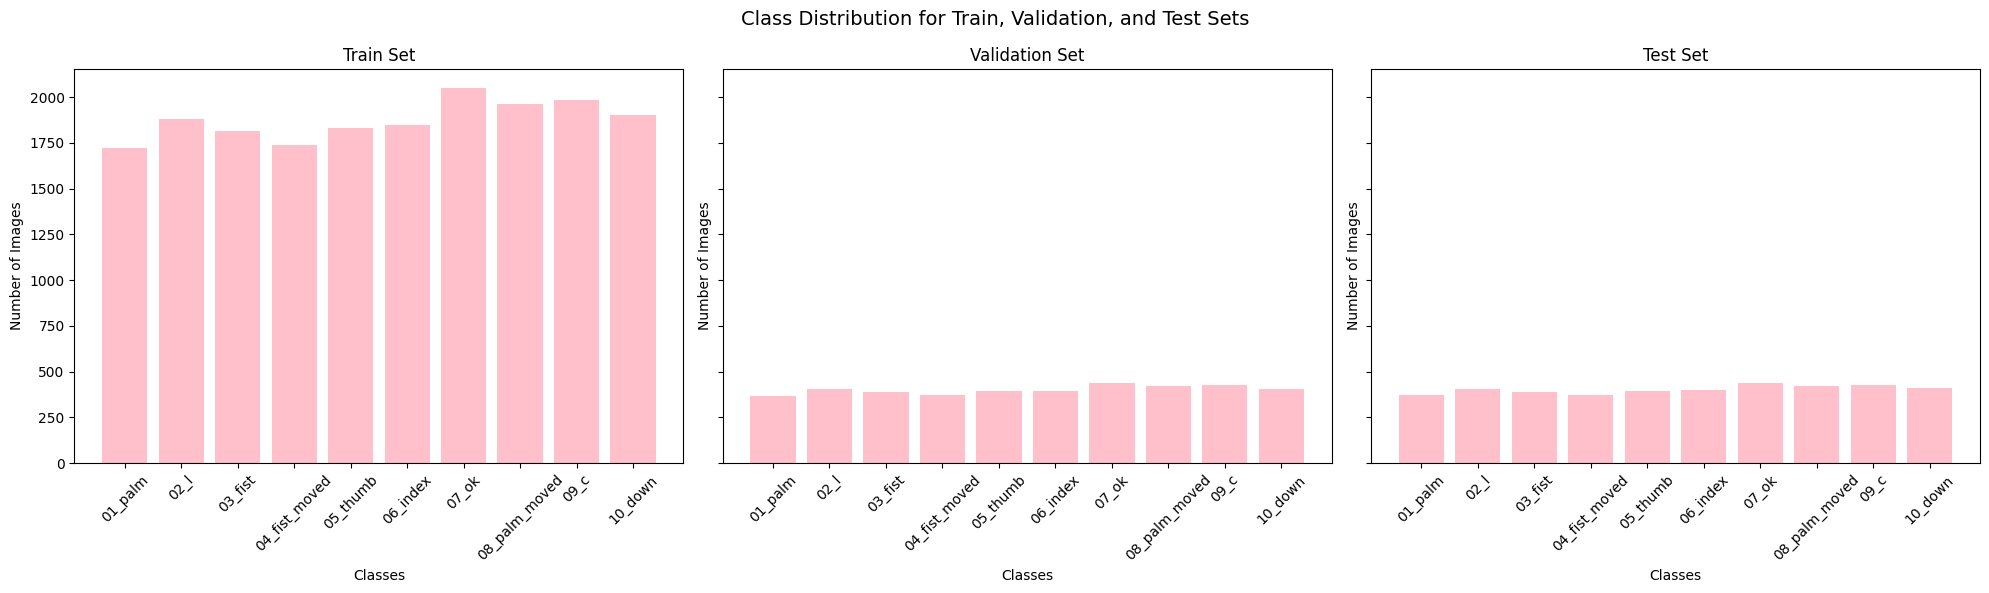

In [ ]:
# Class Distribution
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

datasets = [("Train Set", train_counts),
            ("Validation Set", val_counts),
            ("Test Set", test_counts)]

for ax, (title, counts) in zip(axes, datasets):
    ax.bar(counts.keys(), counts.values(), color="pink")
    ax.set_title(title)
    ax.set_xlabel("Classes")
    ax.set_ylabel("Number of Images")
    ax.tick_params(axis='x', rotation=45)

plt.suptitle("Class Distribution for Train, Validation, and Test Sets", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# step 2: Image properties

# Shape of Images and labels in one batch
for images, labels in train_ds.take(1):
    print("Images batch shape:", images.shape)   # (batch_size, height, width, channels)
    print("Labels batch shape:", labels.shape)

    # Check one image
    img = images[0].numpy()
    print("Image shape:", img.shape)
    print("Image dtype:", img.dtype)

    # Check Dtype & Value Range Across the whole batch
    batch_min = images.numpy().min()
    batch_max = images.numpy().max()
    batch_mean = images.numpy().mean()
    batch_std = images.numpy().std()

    print("Min pixel value in batch:", batch_min)
    print("Max pixel value in batch:", batch_max)
    print("Mean pixel value in batch:", batch_mean)
    print("Std pixel value in batch:", batch_std)


Images batch shape: (256, 224, 224, 3)
Labels batch shape: (256,)
Image shape: (224, 224, 3)
Image dtype: float32
Min pixel value in batch: 0.0
Max pixel value in batch: 255.0
Mean pixel value in batch: 172.05426
Std pixel value in batch: 45.09621


In [ ]:
def plot_pixel_histogram(dataset, bins=50, num_batches=1):
    """
    Plots histogram of pixel intensities from a given tf.data.Dataset (one or more batches).

    Parameters:
        dataset: batched dataset.
        bins: Number of histogram bins.
        num_batches: Number of batches to sample from (default=1).
    """
    pixel_values = []

    for i, (images, labels) in enumerate(dataset.take(num_batches)):
        # Convert batch to numpy
        batch_array = images.numpy().flatten()
        pixel_values.extend(batch_array)

    pixel_values = np.array(pixel_values)

    # Plot histogram
    plt.figure(figsize=(8, 6))
    plt.hist(pixel_values, bins=bins, color="green", edgecolor="black", alpha=0.8)
    plt.title("Pixel Intensity Distribution")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

    # stats
    print(f"\nAnalyzed {num_batches} batch")
    print(f"Total pixels analyzed: {len(pixel_values):,}")
    print(f"Min: {pixel_values.min():.2f}, Max: {pixel_values.max():.2f}, Mean: {pixel_values.mean():.2f}, Std: {pixel_values.std():.2f}")


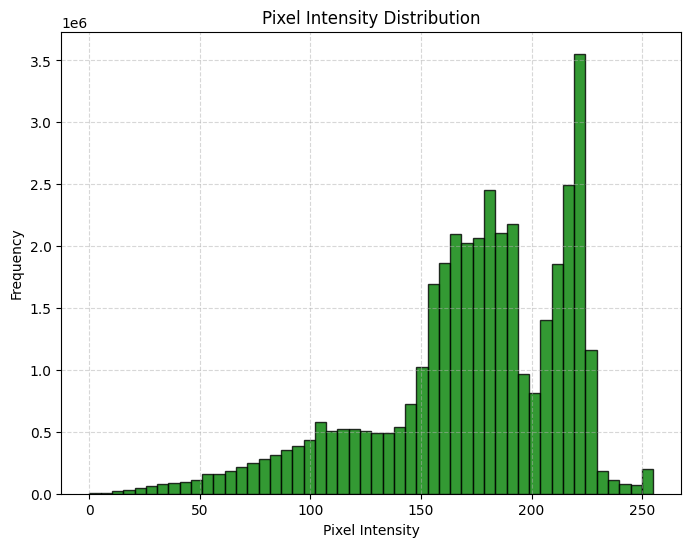


Analyzed 1 batch
Total pixels analyzed: 38,535,168
Min: 0.00, Max: 255.00, Mean: 173.00, Std: 43.74


In [ ]:
# Histogram of train_ds
plot_pixel_histogram(train_ds, bins=50, num_batches=1)

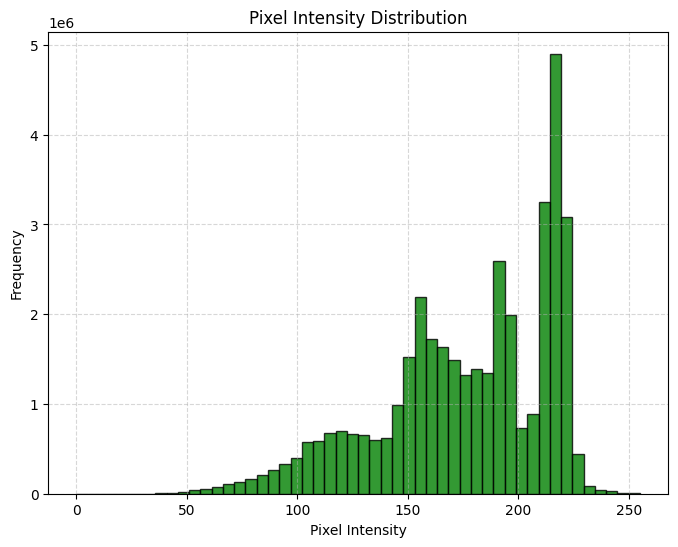


Analyzed 1 batch
Total pixels analyzed: 38,535,168
Min: 0.00, Max: 255.00, Mean: 176.97, Std: 38.64


In [ ]:
# Histogram of test_ds
plot_pixel_histogram(test_ds, bins=50, num_batches=1)

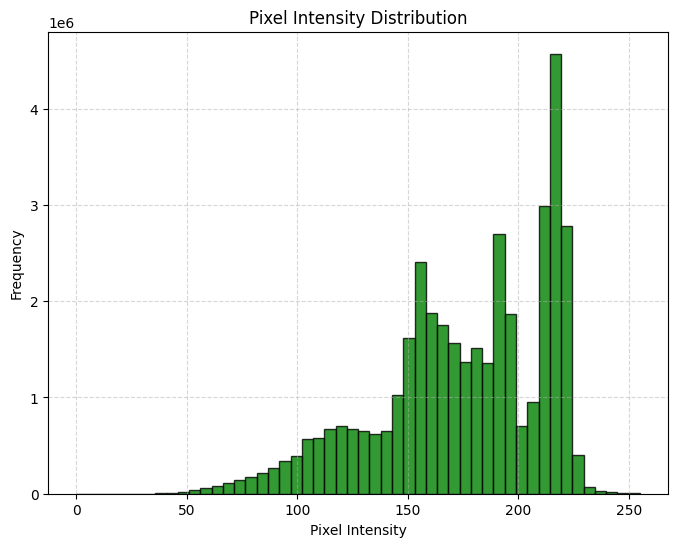


Analyzed 1 batch
Total pixels analyzed: 38,535,168
Min: 0.00, Max: 255.00, Mean: 175.48, Std: 38.25


In [ ]:
# Histogram of test_ds
plot_pixel_histogram(val_ds, bins=50, num_batches=1)

**Key Observations**

Step 1: Dataset Structure & Class Distribution

  - The dataset contains 10 classes.

    - Each class has around:

    - **1900** images in the training set

    - **400** images in the validation set

    - **400** images in the test set

- This results in around 2500 images per class and a total of 26,000 images overall.

The dataset is balanced, meaning no class imbalance issues were found.

---
Step 2: Image Properties

- All images are of shape 224 × 224 × 3 in RGB format.

- Images are stored as float32, with pixel values ranging between 0 and 255.

- Pixel intensity analysis across batches showed:

  - Minimum: 0.0

  - Maximum: 255.0

  - Mean: 172.05

  - Standard deviation: 45.10

- This indicates that the images are bright and well-lit, with good color coverage across the RGB spectrum, with no anomalies or missing data.

**Overall, the images are in a standard format and are ready for preprocessing.**